# Lab 4.3: Introduction to Convolutional Neural Networks

## Duration: 45 minutes

## Learning Objectives
By the end of this lab, you will be able to:
- Understand why CNNs are perfect for image data
- Build your first CNN using TensorFlow/Keras
- Compare CNN performance with regular Dense networks
- Use Conv2D, MaxPooling, and Flatten layers
- Apply CNNs to real image classification problems

## Prerequisites
- **Lab 4.1 & 4.2 completed** (TensorFlow basics and deep networks)
- Understanding of neural networks
- Basic knowledge of images as data

## Key Concepts
- **Convolution**: Feature detection using filters/kernels
- **Pooling**: Dimensionality reduction and translation invariance
- **Feature Maps**: How CNNs detect patterns at different scales
- **Spatial Hierarchy**: Learning from simple edges to complex objects
- **Parameter Sharing**: Why CNNs need fewer parameters than Dense layers

## Setup and Introduction

Let's start by understanding why we need CNNs for image data:

Lab 4.3: Introduction to Convolutional Neural Networks
TensorFlow version: 2.20.0

Loading MNIST dataset...
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Number of classes: 10

📊 Sample MNIST Images:


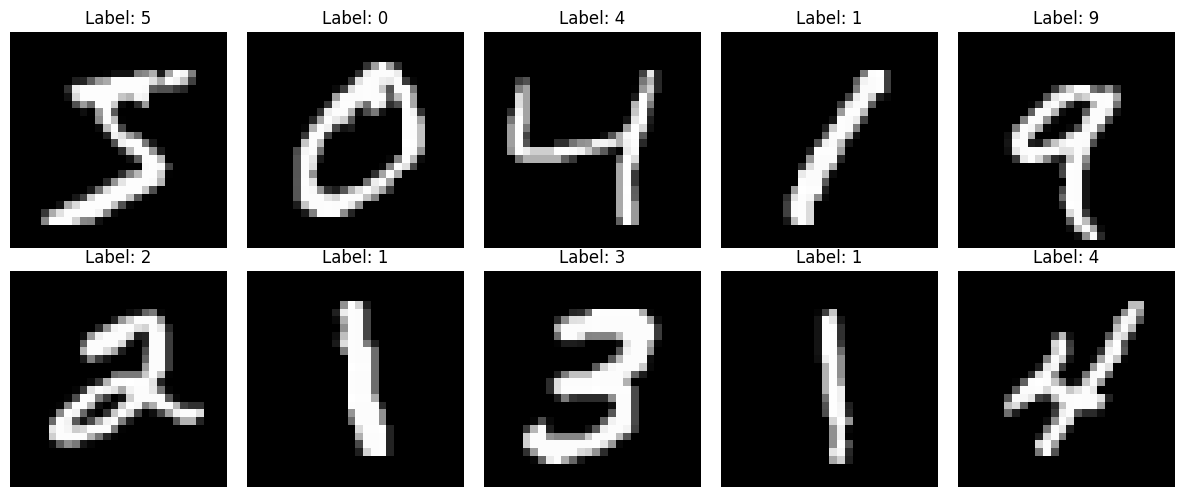


✅ Data loaded and ready for CNN experiments!


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Lab 4.3: Introduction to Convolutional Neural Networks")
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")

# Load the MNIST dataset
print("\nLoading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Visualize some sample images
print("\n📊 Sample MNIST Images:")
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print("\n✅ Data loaded and ready for CNN experiments!")

In [29]:
print("The Dense Network Approach:")
print("=" * 40)

# For Dense layers, we need to flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Original image shape: {X_train.shape[1:]}")
print(f"Flattened shape: {X_train_flat.shape[1:]}")
print(f"Total pixels per image: {X_train_flat.shape[1]}")

# Build a Dense network
dense_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='Dense_Network')

dense_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nDense Model Summary:")
dense_model.summary()

print(f"\nTotal parameters in Dense model: {dense_model.count_params():,}")
print("\n❗ Problems with Dense approach:")
print("  • Loses spatial information (pixel relationships)")
print("  • Treats each pixel independently")
print("  • Lots of parameters (prone to overfitting)")
print("  • Not translation invariant")
print("  • Computationally expensive")

# Train briefly
print("\nTraining Dense network (this may take a moment...)")
dense_history = dense_model.fit(
    X_train_flat, y_train,
    validation_data=(X_test_flat, y_test),
    epochs=5,
    batch_size=128,
    verbose=1
)

dense_accuracy = dense_history.history['val_accuracy'][-1]
print(f"Dense network accuracy: {dense_accuracy:.4f}")

The Dense Network Approach:
Original image shape: (28, 28)
Flattened shape: (784,)
Total pixels per image: 784

Dense Model Summary:


Model: "Dense_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters in Dense model: 109,386

❗ Problems with Dense approach:
  • Loses spatial information (pixel relationships)
  • Treats each pixel independently
  • Lots of parameters (prone to overfitting)
  • Not translation invariant
  • Computationally expensive

Training Dense network (this may take a moment...)
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.9083 - loss: 0.3302 - val_accuracy: 0.9532 - val_loss: 0.1557
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.9607 - loss: 0.1333 - val_accuracy: 0.9652 - val_loss: 0.1087
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.9729 - loss: 0.0929 - val_accuracy: 0.9710 - val_loss: 0.0911
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.9791 - loss: 0.0704 - val_accuracy: 0.9725 - val_loss: 0.0861
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.9836 - loss: 0.0549 - val_accuracy: 0.9744 - val_loss: 0.0839
Dense network accuracy: 0.9744


## Step 4: Visualizing CNN Features

Now let's visualize what the CNN actually learns to detect:

In [ ]:
## Step 3: Understanding CNN Layer Architecture

Let's see what CNN actually learns and how layers work together:

## Step 5: Experimenting with Different CNN Architectures

Let's try different CNN designs and see how architecture choices affect performance:

In [ ]:
print("Experimenting with Different CNN Architectures:")
print("=" * 60)

# Architecture 1: Shallow CNN (fewer layers)
shallow_cnn = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
], name='Shallow_CNN')

# Architecture 2: Deep CNN (more layers)
deep_cnn = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
], name='Deep_CNN')

# Architecture 3: CNN with larger filters
large_filter_cnn = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='Large_Filter_CNN')

# Compare architectures
architectures = {
    'Shallow CNN': shallow_cnn,
    'Deep CNN': deep_cnn,
    'Large Filter CNN': large_filter_cnn,
    'Original CNN': cnn_model
}

print("\n📊 Architecture Comparison:")
print("-" * 40)
for name, model in architectures.items():
    # Build model to get parameter count
    if name != 'Original CNN':  # Original is already built
        model.build(input_shape=(None, 28, 28, 1))
    
    total_params = model.count_params()
    conv_layers = sum(1 for layer in model.layers if 'conv' in layer.__class__.__name__.lower())
    
    print(f"\n{name}:")
    print(f"  • Total parameters: {total_params:,}")
    print(f"  • Conv layers: {conv_layers}")
    print(f"  • Architecture depth: {len(model.layers)} layers")

# Train and compare the shallow model
print("\n🔬 Training Shallow CNN for comparison...")
shallow_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

shallow_history = shallow_cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=3,
    batch_size=128,
    verbose=0
)

shallow_accuracy = max(shallow_history.history['val_accuracy'])

print(f"\nPerformance Comparison:")
print(f"  • Dense Network: {dense_accuracy:.4f}")
print(f"  • Shallow CNN: {shallow_accuracy:.4f}")
print(f"  • Original CNN: {cnn_accuracy:.4f}")

print("\n💡 Key Insights:")
print("  • Even shallow CNNs outperform dense networks")
print("  • Deeper networks can learn more complex features")
print("  • Filter size affects receptive field")
print("  • More parameters ≠ always better (risk of overfitting)")

# Visualize the architectures side by side
plt.figure(figsize=(15, 8))

# Plot training curves comparison
plt.subplot(2, 2, 1)
plt.plot(dense_history.history['val_accuracy'], label='Dense Network', linewidth=2)
plt.plot(shallow_history.history['val_accuracy'], label='Shallow CNN', linewidth=2)
plt.plot(cnn_history.history['val_accuracy'][:3], label='Original CNN', linewidth=2)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot parameter counts
plt.subplot(2, 2, 2)
model_names = ['Dense', 'Shallow CNN', 'Original CNN']
param_counts = [dense_model.count_params(), shallow_cnn.count_params(), cnn_model.count_params()]
colors = ['red', 'yellow', 'green']
bars = plt.bar(model_names, param_counts, color=colors, alpha=0.7)
plt.title('Parameter Count Comparison')
plt.ylabel('Number of Parameters')
for bar, count in zip(bars, param_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{count:,}', ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Show sample predictions
plt.subplot(2, 2, 3)
sample_idx = 10
sample_img = X_test_cnn[sample_idx:sample_idx+1]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f'Test Image (True Label: {y_test[sample_idx]})')
plt.axis('off')

# Prediction comparison
plt.subplot(2, 2, 4)
dense_pred = dense_model.predict(X_test_flat[sample_idx:sample_idx+1], verbose=0)[0]
shallow_pred = shallow_cnn.predict(sample_img, verbose=0)[0]
cnn_pred = cnn_model.predict(sample_img, verbose=0)[0]

x = np.arange(10)
width = 0.25
plt.bar(x - width, dense_pred, width, label='Dense', alpha=0.7)
plt.bar(x, shallow_pred, width, label='Shallow CNN', alpha=0.7)
plt.bar(x + width, cnn_pred, width, label='Original CNN', alpha=0.7)
plt.xlabel('Digit Class')
plt.ylabel('Probability')
plt.title('Prediction Comparison')
plt.legend()
plt.xticks(x)

plt.tight_layout()
plt.show()

print("\n🎯 Conclusion: CNNs consistently outperform Dense networks on image data!")

## Step 4: Visualizing CNN Features\n\nLet's see what the CNN actually learns to detect:"

In [30]:
print("Understanding CNN Layers:")
print("=" * 50)

# Let's build a simple CNN and examine each layer
simple_cnn = keras.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    layers.Conv2D(16, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    layers.Flatten(name='flatten'),
    layers.Dense(10, activation='softmax', name='classifier')
])

print("Layer-by-layer analysis:")
print("-" * 30)

# Trace through the network
input_shape = (28, 28, 1)
print(f"Input: {input_shape} → Raw 28x28 grayscale image")

for i, layer in enumerate(simple_cnn.layers):
    # Build the model up to this layer to see output shape
    temp_model = keras.Sequential(simple_cnn.layers[:i+1])
    temp_model.build(input_shape=(None,) + input_shape)
    output_shape = temp_model.output_shape[1:]  # Remove batch dimension
    
    if 'conv' in layer.name:
        filters = layer.filters
        kernel_size = layer.kernel_size
        print(f"{layer.name}: {output_shape} → {filters} filters of {kernel_size} detecting features")
    elif 'pool' in layer.name:
        pool_size = layer.pool_size
        print(f"{layer.name}: {output_shape} → Downsample by {pool_size}, keep strongest signals")
    elif 'flatten' in layer.name:
        print(f"{layer.name}: {output_shape} → Convert 2D feature maps to 1D vector")
    elif 'dense' in layer.name or 'classifier' in layer.name:
        units = layer.units
        print(f"{layer.name}: {output_shape} → Final classification into {units} classes")

print("\n🔍 Key Insights:")
print("  • Each Conv2D layer detects increasingly complex features")
print("  • MaxPooling reduces size while keeping important information")
print("  • Flatten converts spatial features to vector for classification")
print("  • Final Dense layer maps features to class probabilities")

Understanding CNN Layers:
Layer-by-layer analysis:
------------------------------
Input: (28, 28, 1) → Raw 28x28 grayscale image
conv1: (26, 26, 8) → 8 filters of (3, 3) detecting features
pool1: (13, 13, 8) → Downsample by (2, 2), keep strongest signals
conv2: (11, 11, 16) → 16 filters of (3, 3) detecting features
pool2: (5, 5, 16) → Downsample by (2, 2), keep strongest signals
flatten: (400,) → Convert 2D feature maps to 1D vector
classifier: (10,) → Final classification into 10 classes

🔍 Key Insights:
  • Each Conv2D layer detects increasingly complex features
  • MaxPooling reduces size while keeping important information
  • Flatten converts spatial features to vector for classification
  • Final Dense layer maps features to class probabilities


In [ ]:
## Step 2: The CNN Solution - Convolutional Layers

Now let's build a CNN and see why it's so much better for image data:

In [32]:
print("The Dense Network Approach:")
print("=" * 40)

# For Dense layers, we need to flatten images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Original image shape: {X_train.shape[1:]}")
print(f"Flattened shape: {X_train_flat.shape[1:]}")
print(f"Total pixels per image: {X_train_flat.shape[1]}")

# Build a Dense network
dense_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
], name='Dense_Network')

dense_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nDense Model Summary:")
dense_model.summary()

print(f"\nTotal parameters in Dense model: {dense_model.count_params():,}")
print("\n❗ Problems with Dense approach:")
print("  • Loses spatial information (pixel relationships)")
print("  • Treats each pixel independently")
print("  • Lots of parameters (prone to overfitting)")
print("  • Not translation invariant")
print("  • Computationally expensive")

# Train briefly
print("\nTraining Dense network (this may take a moment...)")
dense_history = dense_model.fit(
    X_train_flat, y_train,
    validation_data=(X_test_flat, y_test),
    epochs=5,
    batch_size=128,
    verbose=1
)

dense_accuracy = dense_history.history['val_accuracy'][-1]
print(f"Dense network accuracy: {dense_accuracy:.4f}")

The Dense Network Approach:
Original image shape: (28, 28)
Flattened shape: (784,)
Total pixels per image: 784

Dense Model Summary:


Model: "Dense_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters in Dense model: 109,386

❗ Problems with Dense approach:
  • Loses spatial information (pixel relationships)
  • Treats each pixel independently
  • Lots of parameters (prone to overfitting)
  • Not translation invariant
  • Computationally expensive

Training Dense network (this may take a moment...)
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9067 - loss: 0.3311 - val_accuracy: 0.9528 - val_loss: 0.1589
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9616 - loss: 0.1321 - val_accuracy: 0.9659 - val_loss: 0.1096
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.9736 - loss: 0.0904 - val_accuracy: 0.9728 - val_loss: 0.0882
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.9802 - loss: 0.0677 - val_accuracy: 0.9746 - val_loss: 0.0798
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.9847 - loss: 0.0523 - val_accuracy: 0.9750 - val_loss: 0.0795
Dense network accuracy: 0.9750
